# Benchmarks for distributed Asynchronous Remote Key Generation (dARKG)

## References

1. [BLS12-381 curve parameters](https://datatracker.ietf.org/doc/html/draft-irtf-cfrg-pairing-friendly-curves-02)
2. [Overview of the BLS12-381 curve](https://hackmd.io/@benjaminion/bls12-381)
3. [Computing pairings using the sextic twist of BLS12-381 in Sage](https://ask.sagemath.org/question/74403/points-must-be-on-same-curve-ate_pairing-bls12-381/)

## One-round Publicly verifiable Asymmetric Key Agreement 

### BLS12-381 Setup

In [96]:
# Parameters for BLS12-381 
z = -0xD201000000010000
q = (z^4 - z^2 + 1)
p = ZZ( z + q*(z - 1)^2/3 )

F = GF(p)
F12.<a> = GF(p^12)
RF.<T> = PolynomialRing(F12)
u = (T^2 + 1).roots(ring=F12, multiplicities=0)[0]

E0 = EllipticCurve(F  , [0, 4])
E1 = EllipticCurve(F12, [0, 4])
E2 = EllipticCurve(F12, [0, 4 + 4*u])

order = E0.order()
k = 12
t = p + 1 - order

# Generators of G1 and G2
x1 = 0x17F1D3A73197D7942695638C4FA9AC0FC3688C4F9774B905A14E3A3F171BAC586C55E83FF97A1AEFFB3AF00ADB22C6BB
y1 = 0x08B3F481E3AAA0F1A09E30ED741D8AE4FCF5E095D5D00AF600DB18CB2C04B3EDD03CC744A2888AE40CAA232946C5E7E1
g1 = E1((x1, y1))
x2 = ( 0x024AA2B2F08F0A91260805272DC51051C6E47AD4FA403B02B4510B647AE3D1770BAC0326A805BBEFD48056C8C121BDB8
       + 0x13E02B6052719F607DACD3A088274F65596BD0D09920B61AB5DA61BBDC7F5049334CF11213945D57E5AC7D055D042B7E * u )
y2 = ( 0x0CE5D527727D6E118CC9CDC6DA2E351AADFD9BAA8CBDD3A76D429A695160D12C923AC9CC3BACA289E193548608B82801
       + 0x0606C4A02EA734CC32ACD2B02BC28B99CB3E287E85A763AF267492AB572E99AB3F370D275CEC1DA1AAA9075FF05F79BE * u )
g2 = E2((x2,y2) )

# Send G2 to E1(F2)
phi = E2.isomorphism_to(E1)

# Define pairing e
e = lambda P,Q: P.ate_pairing(phi(Q), q, k, t, p)

### Global parameters

In [240]:
n = 2^3 # Number of proxies in the group

sec = 128 # Security parameter (as set for BLS12-381)^
gamma = 20 # log_2 bound on the cleartext space to search for in additive ElGamal encryption
B = floor( 2^gamma / n ) # Actual maximum size of cleartexts in an encryption chunk for ElGamal to allow for m-additivity
M = ceil( 2*sec / (gamma * math.log(2) - log(n)) ) # Number of chunks required to encrypt a sec-long message

import random
random.seed(int(0))
from __future__ import print_function
import sys
import time

#### Growth of the size of individual ciphertexts (made of chunks) with respect to the number of proxies in the group.
Since we use ElGamal encryption in the exponent to verify and aggregate ciphertexts, we need to be able to search the corresponding cleartext space. 
This is possible using the Baby Step Giant Step (BSGS) algorithm which has complexity $\mathcal{O}(2^{\gamma/2})$ if the cleartext space is the range $[0, 2^{\gamma}]$. 
As we need to encrypt DL secret keys (shares) in $Z_q$, where $q$ is around $2\lambda$ bits, we split these shares into $M$ digits in base $\gamma$.

Since we actually want to take advantage of the additive homomorphism, we split the shares into digits in base $B=\gamma/n$. 
All the digits are encrypted for each other proxy in the group leading to $M\cdot n$ ciphertexts.
The formula for the number of digits $M$ (and so chunks in a ciphertext) is given by  $$\lceil2\lambda/(\gamma\log(2)-\log(n)) \rceil$$

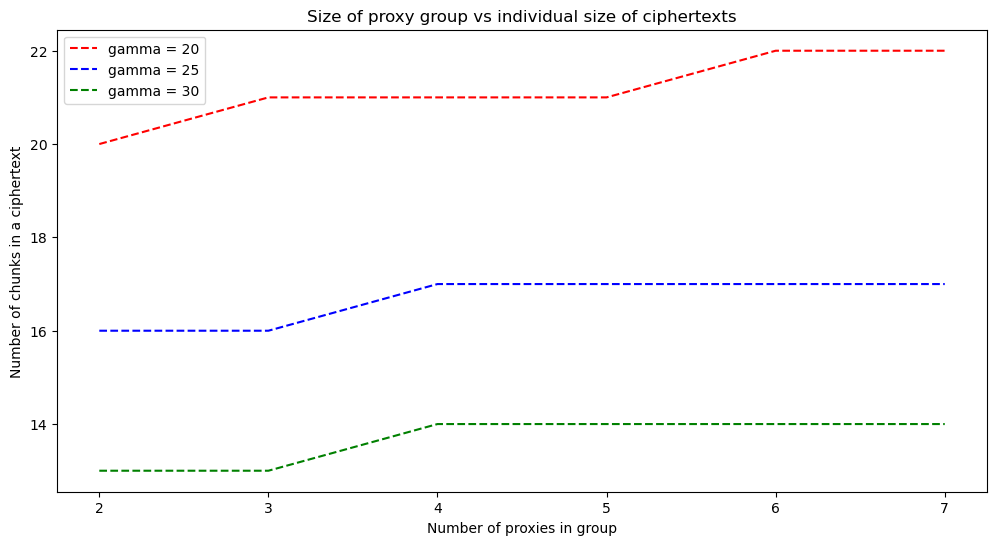

In [241]:
import matplotlib.pyplot as plt
MAX_GROUP_SIZE = 2^3
g_low, g_mid, g_high = 20, 25, 30

M_func = lambda n, g: ceil( 2*sec / (g * math.log(2) - log(n)) )

x_axis = range(2, MAX_GROUP_SIZE)
gamma_low = [M_func(n, g_low) for n in x_axis]
gamma_mid = [M_func(n, g_mid) for n in x_axis]
gamma_high = [M_func(n, g_high) for n in x_axis]

plt.figure(figsize=(12,6))
plt.plot(x_axis, gamma_low, 'r--', x_axis, gamma_mid, 'b--', x_axis, gamma_high, 'g--')
plt.ylabel('Number of chunks in a ciphertext')
plt.xlabel('Number of proxies in group')
plt.title('Size of proxy group vs individual size of ciphertexts')
plt.legend(['gamma = {}'.format(g_low), 'gamma = {}'.format(g_mid), 'gamma = {}'.format(g_high)])
plt.show()

### Long-term keys generation

In [242]:
def KGen():
    dk = F.random_element()
    ek = dk*g1
    return (dk, ek)

### Dealing

In [243]:
def genDecomposedShare():
    sh_parts = [random.randint(0, B) for _ in range(M)]
    sh = sum([sh_parts[k] * B^k for k in range(M)])
    return sh, sh_parts

def encryptElGamal(ek, cache_msg, r):
    ct = r * ek + cache_msg
    return ct

def deal(ekn):
    n = len(ekn)
    sh, sh_parts = genDecomposedShare()
    r, w = random.randint(0, order-1), random.randint(0, order-1)

    ct0 = r*g1
    ct1 = {i: {} for i in range(n)}
    cache_msg = [sh_parts[k]*g1 for k in range(M)] 
    for i in range(n):
        for k in range(M):
            ct1[i][k] = encryptElGamal(LTK_ek[i], cache_msg[k], r)
    ct2 = (sh*g1, (r*w)*g2, w*g2)
    
    d = (ct0, ct1, ct2)
    return (sh, d)

### Verify

In [244]:
def verify(ekn, d):
    # Parse ciphertext
    ct0, ct1, ct2 = d[0], d[1], d[2]
    R = ct0
    S, U, W = ct2
    
    n = len(ct1)
    beta = sum([B^k for k in range(M)])

    # Check binding
    if not e(R, W) == e(g1, U): return 0

    # Check ciphertexts
    cache_esw = e(S, W)^(-1)
    cache_ubeta = beta*U
    for i in range(n):    
        Pi = 1
        for k in range(M):
            Pi *= e(ct1[i][k], W)^(B^k)
            if not ( Pi*cache_esw == e(ekn[i], cache_ubeta) ): return 0
    return 1

### Combine public key

In [245]:
from operator import mul
def mul_lambda(lst):
    # Should be replaced with sum?
    return  reduce(lambda x, y: x + y, lst)

def combinePK(dn):       
    # Parse ciphertexts
    n = len((dn.keys()))
    ct0_lst = [dn[i][0] for i in range(n)]
    
    # Compute pk
    pk = 0x0*g1
    for i in range(n): pk += dn[i][2][0]  

    # Compute R
    R = mul_lambda( ct0_lst ) # # #  

    # Aggregate ciphertexts
    f_lst = {i:(R, {}) for i in range(n) }
    for i in range(n): 
        for k in range(M):
            f_lst[i][1][k] = (mul_lambda( [dn[j][1][i][k] for j in range(n)] ))
    return pk, f_lst

### Combine secret key

In [246]:
def decryptElGamalBatch(dk, ctn):
    # Batch version to attempt to speed up DL, could be parallelized
    R, cn = ctn[0], ctn[1]
    m_lst = []
    m_exp = [cn[k] - dk*R for k in range(M)]

    # find DLog of m_exp in base g1
    timings_sum = 0
    timing_loop = time.time()
    for k in range(M):
        t_start = time.time()
        m_lst.append(discrete_log(m_exp[k], g1, order, algorithm='bsgs', bounds= (0, 2^gamma),operation='+'))
        print('Recovered digit {} of (sk-sh) out of M={} in : {}s'.format(k, M-1, time.time()-t_start), end='\r'); sys.stdout.flush()
        timings_sum += (time.time() - t_start)
    print('Recovered sk in {}s, each digit taking on average {}s'.format(time.time()-timing_loop, round(timings_sum/M, 2)), end='\r'); sys.stdout.flush()    
    return m_lst

def combineSK(dk, sh, f):
    # Decipher f[1] into digits of sk-sh
    digits_lst = []
    digits = decryptElGamalBatch(dk, f)

    # Recompose sk
    sk_ = sum([digits[k] * B^k for k in range(M)])
    return sk_ # Would normally add own share sh if not self-encrypting it in the dealings

### Benchmarks

#### 1) Proxy Long-term key generation

In [247]:
LTK = [KGen() for _ in range(n)]
LTK_dk, LTK_ek = list(zip(*LTK))

#### 2) Selection of a group of proxies by the delegator

In [248]:
ekn = [ek for ek in LTK_ek[0:n]]

#### 3) Proxy dealing generation

In [249]:
dealings, shares = {}, {}
timings_sum = 0
for i in range(n):
    print('Currently generating dealing for proxy {}'.format(i), end='\r'); sys.stdout.flush() 
    t_start = time.time()
    shares[i], dealings[i] = deal(ekn)
    timings_sum += (time.time() - t_start)
print('{} proxy dealings completed in {}s on average'.format(n, round(timings_sum/n, 2), end='\r'))

8 proxy dealings completed in 3.87s on average


#### 4) Verify dealings

In [250]:
qual = []
i = 1
timings_sum = 0
for i in range(n):
    print('Currently verifying dealing for proxy {}'.format(i), end='\r'); sys.stdout.flush()
    t_start = time.time()
    if verify(ekn, dealings[i]): qual.append(i)
    timings_sum += (time.time() - t_start)
    i+=1
if len(qual) < t: print("Abort: Not enough qualified proxies")
print('{} proxy verifications completed in {}s on average'.format(n, round(timings_sum/n, 2), end='\r'))

8 proxy verifications completed in 0.9s on average


#### 5) Combine public keys

In [251]:
print('Combining public keys', end='\r'); sys.stdout.flush()
t_start = time.time()
pk, f_lst = combinePK(dealings)
print('PK combination completed in {}'.format( round(time.time() - t_start, 2), end='\r'))

PK combination completed in 0.05


#### 6) Combine secret keys

In [254]:
proxy_index = 0
t_start = time.time()
dk_proxy, sh_proxy, f_proxy = LTK_dk[proxy_index], shares[proxy_index], f_lst[proxy_index]
sk = combineSK(dk_proxy, sh_proxy, f_proxy)
print('SK combination completed in {}s'.format( round(time.time() - t_start, 2), end='\r'))

SK combination completed in 3.22s3s, each digit taking on average 0.14s


In [253]:
assert sk*g1 == pk
print("Success")

Success
